In [64]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


In [65]:
file_path = 'adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
adult_df = pd.read_csv(file_path, names=columns, na_values="?", skipinitialspace=True)

# Binary indicators for capital gains and losses
adult_df['positive_capital_gain'] = (adult_df['capital-gain'] > 0).astype(int)
adult_df['positive_capital_loss'] = (adult_df['capital-loss'] > 0).astype(int)

# Interaction feature between age and education-num
adult_df['age_education_interaction'] = adult_df['age'] * adult_df['education-num']

# Aggregating less common categories into 'Other'
top_occupations = adult_df['occupation'].value_counts().nlargest(5).index
adult_df['occupation_aggregated'] = adult_df['occupation'].apply(lambda x: x if x in top_occupations else 'Other')

top_countries = adult_df['native-country'].value_counts().nlargest(5).index
adult_df['native_country_aggregated'] = adult_df['native-country'].apply(lambda x: x if x in top_countries else 'Other')

# Binning age and hours-per-week
age_bins = [0, 25, 35, 45, 55, 65, 100]
age_labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '66+']
adult_df['age_binned'] = pd.cut(adult_df['age'], bins=age_bins, labels=age_labels, right=False)

hours_bins = [0, 20, 30, 40, 50, 100]
hours_labels = ['0-20', '21-30', '31-40', '41-50', '51+']
adult_df['hours_per_week_binned'] = pd.cut(adult_df['hours-per-week'], bins=hours_bins, labels=hours_labels, right=False)

adult_df = adult_df.drop(['age', 'hours-per-week', 'occupation', 'native-country'], axis=1)

In [66]:
bank_df = pd.read_csv('bank.csv', delimiter=';')

# Aggregating less common categories into 'Other'
top_jobs = bank_df['job'].value_counts().nlargest(5).index
bank_df['job_aggregated'] = bank_df['job'].apply(lambda x: x if x in top_jobs else 'Other')

# Binning age and hours-per-week
age_bins = [0, 25, 35, 45, 55, 65, 75, 100]
age_labels = ['0-25', '26-35', '36-45', '46-55', '56-65', '66-75', '75+']
bank_df['age_binned'] = pd.cut(bank_df['age'], bins=age_bins, labels=age_labels, right=False)

bank_df = bank_df.drop(['age', 'job'], axis=1)

In [67]:
def preprocess(df, target_column=None):
    df = df.dropna()
    
    y = df[target_column] if target_column else None
    if target_column:
        df = df.drop(columns=[target_column])

    # Identify categorical columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    # Apply one-hot encoding
    df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    
    # Identify numerical columns (excluding dummy variables)
    num_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns
    
    # Standardize numerical features
    scaler = StandardScaler()
    df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])
    
    return (df_encoded, y) if target_column else df_encoded


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from kneed import KneeLocator

def k_distance_curve(data, k):
    """
    Plot the k-distance graph for the dataset to find the optimal epsilon (elbow method).
    """
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, indices = neigh.kneighbors(data)
    
    # Sort distances
    sorted_distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances)
    plt.title("K-Distance Graph")
    plt.xlabel("Points sorted by distance")
    plt.ylabel(f"Distance to {k}-th nearest neighbor")
    plt.grid(True)
    plt.show()

    return sorted_distances

def find_knee_point(sorted_distances):
    """
    Detect the knee point using the 'kneed' library to find the optimal epsilon.
    """
    knee_locator = KneeLocator(range(len(sorted_distances)), sorted_distances, curve='convex', direction='increasing')
    knee_point = knee_locator.knee
    
    plt.figure(figsize=(10, 5))
    plt.plot(sorted_distances)
    plt.scatter(knee_point, sorted_distances[knee_point], color='red', label='Knee point')
    plt.title("K-Distance Graph with Knee Point")
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return sorted_distances[knee_point]

def automated_dbscan(data, k):
    # Calculate sorted distances from the k-distance graph
    sorted_distances = k_distance_curve(data, k)
    
    # Detect knee point to use as an initial epsilon estimate
    initial_epsilon = find_knee_point(sorted_distances)
    eps_range = np.linspace(initial_epsilon * 0.8, initial_epsilon * 1.2, 5)

    # Explore a range for MinPts based on dimensions
    min_pts_range = range(2, k, 5)
    
    best_score = -np.inf
    best_params = {'epsilon': None, 'min_pts': None}
    results = []
    for epsilon in eps_range:
        # Testing different MinPts values
        for min_pts in min_pts_range:
            db = DBSCAN(eps=epsilon, min_samples=min_pts)
            labels = db.fit_predict(data)
            print(f"eps: {epsilon}, minPts: {min_pts}, clusters: {len(set(labels))}")
            if len(set(labels)) > 2:  # Valid clustering check
                silhouette = silhouette_score(data, labels)
                davies_bouldin = davies_bouldin_score(data, labels)
                calinski_harabasz = calinski_harabasz_score(data, labels)
                score = silhouette - davies_bouldin + calinski_harabasz
                results.append({
                    'min_pts': min_pts,
                    'silhouette': silhouette,
                    'davies_bouldin': davies_bouldin,
                    'calinski_harabasz': calinski_harabasz
                })
                print(f"Eps: {epsilon}, MinPts: {min_pts}, Silhouette: {silhouette}, Davies-Bouldin: {davies_bouldin}, Calinski-Harabasz: {calinski_harabasz}")
                
                # Choose metric for optimization, here using silhouette as an example
                if silhouette > best_score:
                    best_score = silhouette
                    best_params['epsilon'] = epsilon
                    best_params['min_pts'] = min_pts

    return best_params, results





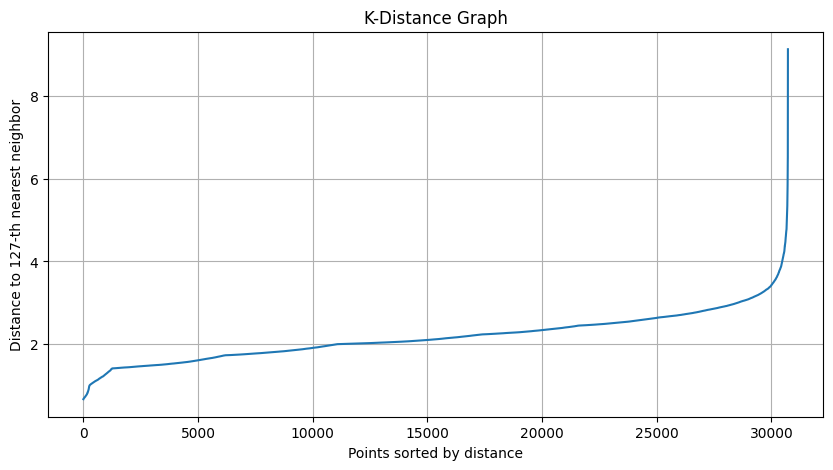

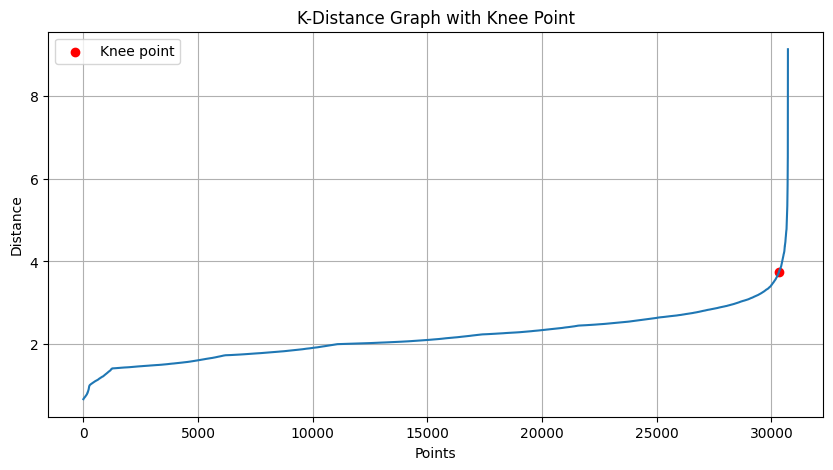

eps: 3.000953866486416, minPts: 2, clusters: 10
Eps: 3.000953866486416, MinPts: 2, Silhouette: 0.2944942673983684, Davies-Bouldin: 1.5673583558716426, Calinski-Harabasz: 1757.138620329105
eps: 3.000953866486416, minPts: 7, clusters: 5
Eps: 3.000953866486416, MinPts: 7, Silhouette: 0.3124750469501575, Davies-Bouldin: 1.7159716535522123, Calinski-Harabasz: 3914.351977530855
eps: 3.000953866486416, minPts: 12, clusters: 5
Eps: 3.000953866486416, MinPts: 12, Silhouette: 0.31218578770241284, Davies-Bouldin: 1.771187730211198, Calinski-Harabasz: 3908.2868112189103
eps: 3.000953866486416, minPts: 17, clusters: 5
Eps: 3.000953866486416, MinPts: 17, Silhouette: 0.31183044878231025, Davies-Bouldin: 1.8109847212591397, Calinski-Harabasz: 3894.1527168838206
eps: 3.000953866486416, minPts: 22, clusters: 5
Eps: 3.000953866486416, MinPts: 22, Silhouette: 0.3117249502889665, Davies-Bouldin: 1.8313766412258534, Calinski-Harabasz: 3891.863655063012
eps: 3.000953866486416, minPts: 27, clusters: 5
Eps: 3.

In [69]:
adult, y = preprocess(adult_df, 'income')

k = 2 * adult.shape[1] - 1
best_params, results = automated_dbscan(adult, k)
print("Best Parameters:", best_params)